### Settings & imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns
from textwrap import wrap

from pathlib import Path

import pandas as pd

import time

In [4]:
nr_of_experiment = 2

### Experiments data

In [5]:
components_dictionary = {'experiment_1': ['Pinene', 'Benzyl benzoate'],
                        'experiment_2': ['Pinene', 'Limonene'],
                        'experiment_7': ['Benzyl benzoate', 'm Anisaldehyde'],
                        'experiment_3': ['Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene'],
                        'experiment_6': ['Pinene', 'Benzyl benzoate'],
                        'experiment_5': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_9': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_4': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_8': ['Benzyl benzoate', 'm Anisaldehyde']}

In [6]:
protons_dictionary = {'experiment_1': [16, 12],
                        'experiment_2': [16, 16],
                        'experiment_7': [12, 8],
                        'experiment_3': [34, 12, 16, 16],
                        'experiment_6': [16, 12],
                        'experiment_5': [4, 4, 5, 5, 13],
                        'experiment_9': [4, 4, 5, 5, 13],
                        'experiment_4': [4, 4, 5, 5, 13],
                        'experiment_8': [12, 8]}

In [7]:
ground_truth_molar_proportions = {'experiment_1': [0.09088457406472417, 0.9091154259352758],
                                    'experiment_2': [0.505, 0.495],
                                    'experiment_7': [0.8403875207510383, 0.1596124792489616],
                                    'experiment_3': [0.7264578344443725, 0.10578603326645526, 0.081968804608116, 0.08578732768105625],
                                    'experiment_6': [0.3865, 0.6135],
                                    'experiment_5': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_9': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_4': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_8': [0.3702, 0.6298]}

In [8]:
experiments_folders = {'experiment_1': 'experiment_1_intensity_difference',
                        'experiment_6': 'experiment_6_miniperfumes',
                        'experiment_5': 'experiment_5_metabolites',
                         'experiment_7': 'experiment_7_overlapping_and_intensity_difference',
                         'experiment_9': 'experiment_9_and_4_shim',
                       'experiment_4': 'experiment_9_and_4_shim',
                        'experiment_8': 'experiment_8_different_solvents',
                        'experiment_3': 'experiment_3_perfumes_and_absent_components',
                         'experiment_2': 'experiment_2_overlapping'}

In [9]:
best_kappa_mix = [0.09, 0.05, 0.37, 0.11, 0.03, 0.06, 0.23, 0.2, 0.05]

In [10]:
best_kappa_model = [0.08, 0.01, 0.24, 0.02, 0.09, 0.2, 0.02, 0.29, 0.02]

### Loading the data

In [11]:
if (nr_of_experiment != 9 and nr_of_experiment != 4):
    filename = experiments_folders['experiment_' + str(nr_of_experiment)] + '/preprocessed_mix.csv'
    mix = np.loadtxt(filename, delimiter=',')
else:
    filename = experiments_folders['experiment_' + str(nr_of_experiment)] + '/preprocessed_exp'+str(nr_of_experiment)+'_mix.csv'
    mix = np.loadtxt(filename, delimiter=',')

In [12]:
how_many_components = len(components_dictionary['experiment_'+str(nr_of_experiment)])
names = ['comp' + str(i) for i in range(how_many_components)]

In [13]:
spectra = []
for i in range(how_many_components):
    if (nr_of_experiment != 9 and nr_of_experiment != 4):
        filename = experiments_folders['experiment_' + str(nr_of_experiment)] + \
                    '/preprocessed_comp' + str(i) + '.csv'
        spectra.append(np.loadtxt(filename, delimiter=','))
    else:
        filename = experiments_folders['experiment_' + str(nr_of_experiment)] + \
                    '/preprocessed_exp'+str(nr_of_experiment)+ '_comp'+ str(i) + '.csv'
        spectra.append(np.loadtxt(filename, delimiter=','))

In [14]:
spectra2 = []
names = []
for i in range(len(spectra)):
    spectra2.append(NMRSpectrum(confs=list(zip(spectra[i][:,0], spectra[i][:,1])), 
                                protons=protons_dictionary['experiment_'+str(nr_of_experiment)][i]))
    names.append('comp'+str(i))

spectra = spectra2
del(spectra2)
mix = NMRSpectrum(confs=list(zip(mix[:,0], mix[:,1])))

In [15]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [16]:
# mix.plot(profile=True)
# for sp in spectra:
#     sp.plot(profile=True)

### Estimation with default kappas

In [17]:
# start_con = time.time()
# estimation_molar = estimate_proportions(mix, spectra,
#                                         MTD=0.25, 
#                                         MTD_th=0.25,
#                                         verbose=True, solver=pulp.GUROBI(msg=False), 
#                                         what_to_compare='concentration')
# stop_con = time.time()

In [18]:
#estimation_molar['proportions']

In [19]:
# #MTD = 0.25, MTD_th = 0.25

# #1: 'Pinene', 'Benzyl benzoate'
# 0.0936, 0.9064

# #2: 'Pinene', 'Limonene'
# 0.5236, 0.4764

# #3: 'Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene'
# 0.7474, 0.1071, 0.0903, 0.0551

# #4: 'Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3165, 0.2137, 0.1342, 0.1957, 0.1398

# #5: 'Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3179, 0.2113, 0.1293, 0.2018, 0.1397

# #6: 'Pinene', 'Benzyl benzoate'
# 0.3930, 0.6070

# #7: 'Benzyl benzoate', 'm Anisaldehyde'
# 0.8429, 0.1571

# #8: 'Benzyl benzoate', 'm Anisaldehyde'
# 0.3761, 0.6239

# #9: Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3180, 0.2125, 0.1335, 0.1965, 0.1395

In [20]:
# #MTD = 0.25, MTD_th = 0.22

# #1: 'Pinene', 'Benzyl benzoate'
# 0.0937, 0.9063

# #2: 'Pinene', 'Limonene'
# 0.5240, 0.4760

# #3: 'Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene'
# 0.7511, 0.1059, 0.0809, 0.0621

# #4: 'Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3165, 0.2137, 0.1341, 0.1960, 0.1397

# #5: 'Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3180, 0.2113, 0.1293, 0.2018, 0.1397

# #6: 'Pinene', 'Benzyl benzoate'
# 0.3931, 0.6069

# #7: 'Benzyl benzoate', 'm Anisaldehyde'
# 0.8428, 0.1572

# #8: 'Benzyl benzoate', 'm Anisaldehyde'
# 0.3762, 0.6238

# #9: Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3180, 0.2125, 0.1333, 0.1967, 0.1395

### Estimation

In [21]:
start_vis = time.time()
estimation_vis = estimate_proportions(mix, spectra,
                                        MTD=best_kappa_mix[nr_of_experiment-1], 
                                        MTD_th=best_kappa_model[nr_of_experiment-1],
                                        verbose=True, solver=pulp.GUROBI(msg=False), 
                                        what_to_compare='area')
stop_vis = time.time()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


Initial filtering of formulas: 100%|██████████████| 2/2 [00:00<00:00, 63.37it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(-1.97165, 13.9718, 0), (-1.97165, 13.9718, 1)]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(-2.0616499999999998, 14.0618)]


Splitting the experimental spectrum into chunks: 131072it [00:00, 3644556.35it/s]


Ion currents in chunks: [1.0000000000000042]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.99s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.9891180058439999
Noise proportion in experimental spectrum: 0.010881994155000015
Total explanation: 0.9999999999989999
Noise proportion in combination of theoretical spectra: 0.021767335575


In [22]:
print('Estimation took '+ str(stop_vis-start_vis) + ' seconds.')

Estimation took 168.102774143219 seconds.


In [23]:
estimation_vis['proportions']

[0.11641497594500048, 0.8727030298990036]

In [24]:
estimation_vis['proportion_of_noise_in_theoretical']

0.02176733557500009

In [25]:
start_con = time.time()
estimation_molar = estimate_proportions(mix, spectra,
                                        MTD=best_kappa_mix[nr_of_experiment-1], 
                                        MTD_th=best_kappa_model[nr_of_experiment-1],
                                        verbose=True, solver=pulp.GUROBI(msg=False), 
                                        what_to_compare='concentration')
stop_con = time.time()

Initial filtering of formulas: 100%|██████████████| 2/2 [00:00<00:00, 62.84it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(-1.97165, 13.9718, 0), (-1.97165, 13.9718, 1)]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(-2.0616499999999998, 14.0618)]


Splitting the experimental spectrum into chunks: 131072it [00:00, 3607866.11it/s]


Ion currents in chunks: [1.0000000000000042]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.32s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.9891180058439999
Noise proportion in experimental spectrum: 0.010881994155000015
Total explanation: 0.9999999999989999
Noise proportion in combination of theoretical spectra: 0.021767335575


In [26]:
print('Estimation took '+ str(stop_con-start_con) + ' seconds.')

Estimation took 167.4535562992096 seconds.


In [27]:
estimation_molar['proportions']

[0.09094784882652851, 0.9090521511734716]

### Saving estimation results

In [28]:
res_vis = pd.DataFrame(np.array(estimation_vis['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_vis

,Pinene,Benzyl benzoate
0,0.116415,0.872703


In [29]:
res_con = pd.DataFrame(np.array(estimation_molar['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_con

,Pinene,Benzyl benzoate
0,0.090948,0.909052


In [30]:
# if (nr_of_experiment != 9 and nr_of_experiment != 4):
#     res_vis.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area.csv')
# else:
#     res_vis.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area_exp'+str(nr_of_experiment)+'.csv')

In [31]:
# if (nr_of_experiment != 9 and nr_of_experiment != 4):
#     res_con.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration.csv')
# else:
#     res_con.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration_exp'+str(nr_of_experiment)+'.csv')

### Mixture vs linear combination of components (noise removed)

In [32]:
ignore_negative = False

In [33]:
def make_nonnegative(ints):
    res_ints = ints
    for col_nr in range(ints.shape[1]):
        neg = ints[:,col_nr]<0
        res_ints[:,col_nr][neg]=0
    return(res_ints)

#### Mix

In [34]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [35]:
mix_without_noise = NMRSpectrum(confs = list(zip(ppm, mix_ints - np.array(estimation_vis['noise']))))
mix_without_noise = np.array(mix_without_noise.confs)[:,1]

In [36]:
if ignore_negative:
    mix_without_noise = make_nonnegative(mix_without_noise.reshape(-1,1))

In [37]:
mix_without_noise = mix_without_noise/sum(mix_without_noise)

#### Components

In [38]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [39]:
p = estimation_vis['proportions']
p = np.array(p).reshape(len(p),1)

In [40]:
names_components_up_to = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [41]:
components = [comp.reshape(-1,1) for comp in components_ints]
components_no_scaling = np.concatenate(components, axis=1)
components_scaled = components_no_scaling*p[:,0]

In [42]:
proportions_point_by_point = (components_scaled/np.sum(components_scaled, axis=1).reshape(-1,1))
proportions_point_by_point = np.nan_to_num(proportions_point_by_point)
noise_in_ref = np.array(estimation_vis['noise_in_theoretical']).reshape(-1,1)
noise_split_for_components = proportions_point_by_point*noise_in_ref

/tmp/ipykernel_39742/2062537961.py:1: RuntimeWarning: invalid value encountered in divide
  proportions_point_by_point = (components_scaled/np.sum(components_scaled, axis=1).reshape(-1,1))


In [43]:
(np.round(components_scaled-noise_split_for_components, decimals=5)>=0).all()

True

In [44]:
X = components_scaled - noise_split_for_components

In [45]:
(np.sum(X[:,:1], axis=1)==X[:,0]).all()

True

In [46]:
if ignore_negative:
    X = make_nonnegative(X)

In [47]:
for i, name in enumerate(names_components_up_to):
    #not_normalized = np.sum(X[:,:(i+1)], axis=1)
    
    globals()[name] = np.sum(X[:,:(i+1)], axis=1)

In [48]:
xlims_lower = [1.55, 1.6, 4.4, 3.55, 3.55, 1.55, 7.3, 9.1, 3.55]
xlims_upper = [2.45, 2.4, 7.8, 4.05, 4.05, 2.4, 7.6, 10.1, 4.05]
ylims_lower = [-0.00005, -0.00005, -0.000025, -0.00005, -0.00005, -0.00005, -0.00005, -0.00005, -0.00005]
ylims_upper = [0.00045, 0.0025, 0.00016, 0.0016, 0.0011, 0.0016, 0.0026, 0.0014, 0.0016]

<IPython.core.display.Javascript object>


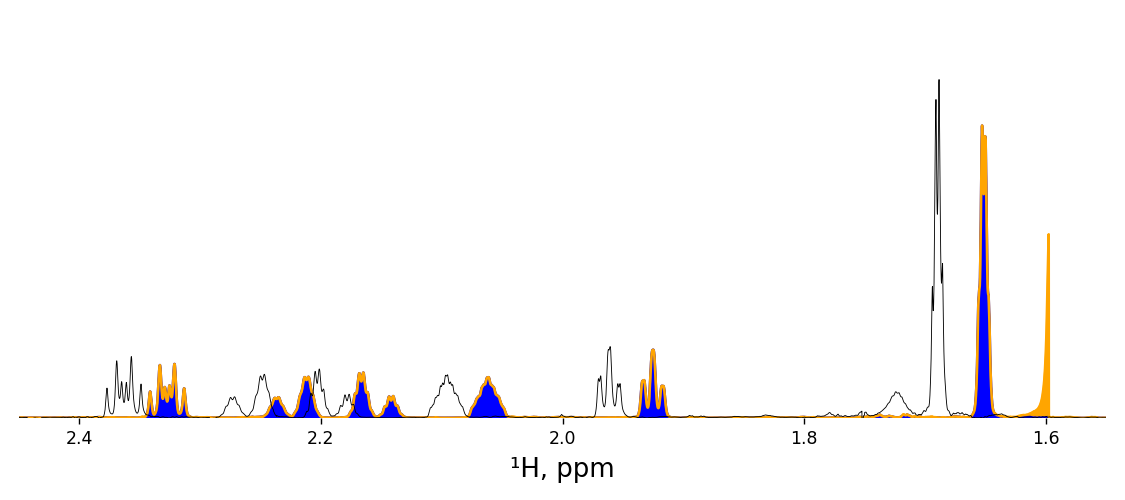

In [49]:
colors = ['blue', 'orange', 'green', 'red', 'pink']
fig, ax = plt.subplots()
fig.set_size_inches(9, 4, forward=True)

ax.set_xlim(xlims_lower[nr_of_experiment-1], xlims_upper[nr_of_experiment-1])
ax.set_ylim(None, ylims_upper[nr_of_experiment-1])
ax.get_yaxis().set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.xlabel(chr(0x00b9)+'H, ppm', fontsize=15, labelpad=5)
#plt.ylabel('Relative intensity', fontsize=15, labelpad=10)

for i, name in enumerate(names_components_up_to):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], 
            label=components_dictionary['experiment_'+str(nr_of_experiment)][i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_without_noise, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
#ax.legend(prop={'size': 12}, loc='upper right')
ax.invert_xaxis()
plt.tight_layout()
plt.savefig(os.getcwd()+'/spectra_visualisation/experiment'+str(nr_of_experiment)+'.jpg', dpi=300)

In [50]:
estimation_vis['proportion_of_noise_in_theoretical']

0.02176733557500009

In [51]:
1-sum(estimation_vis['proportions'])

0.010881994155995889

In [52]:
estimation_vis['proportions']

[0.11641497594500048, 0.8727030298990036]